In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

## Importing data

In [2]:
headers = ['T_Out_AVG', 'T_1ST_AVG', 'T_MBR_AVG', 
           'T_ALT_AVG', 'T_Plenum_AVG', 'RH_Out_AVG', 
           'RH_1ST_AVG', 'RH_MBR_AVG', 'RH_ALT_AVG', 'KWH_TOTAL_TOT']

# Filter the data so that only the selected columns remain
df = pd.read_csv('House_12.csv', usecols=headers)

# Print the information of df
print(df.info())

# Print the head of df
print(df.head())

# Filter the NaNs
df = df.dropna()

# Print the info of df
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14738 entries, 0 to 14737
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   T_Out_AVG      2070 non-null   float64
 1   T_1ST_AVG      2070 non-null   float64
 2   T_MBR_AVG      2070 non-null   float64
 3   T_ALT_AVG      2070 non-null   float64
 4   T_Plenum_AVG   2070 non-null   float64
 5   RH_Out_AVG     2070 non-null   float64
 6   RH_1ST_AVG     2070 non-null   float64
 7   RH_MBR_AVG     2070 non-null   float64
 8   RH_ALT_AVG     2070 non-null   float64
 9   KWH_TOTAL_TOT  2070 non-null   float64
dtypes: float64(10)
memory usage: 1.1 MB
None
   T_Out_AVG  T_1ST_AVG  T_MBR_AVG  T_ALT_AVG  T_Plenum_AVG  RH_Out_AVG  \
0       86.2      150.5      150.0      148.9         153.9       23.72   
1       87.3      148.7      147.1      145.8         147.7       23.42   
2       87.4      143.9      144.3      141.8         126.5       23.37   
3       87.2     

## Filter the data

In [3]:
from utils import filter_outliers

# Filter the outliers
df = filter_outliers(df, z_thresh=3)

## Visualizing the data

               T_Out_AVG  T_1ST_AVG  T_MBR_AVG  T_ALT_AVG  T_Plenum_AVG  \
T_Out_AVG       1.000000   0.614054   0.680122   0.521082      0.392201   
T_1ST_AVG       0.614054   1.000000   0.982460   0.958651      0.582942   
T_MBR_AVG       0.680122   0.982460   1.000000   0.924786      0.591354   
T_ALT_AVG       0.521082   0.958651   0.924786   1.000000      0.655584   
T_Plenum_AVG    0.392201   0.582942   0.591354   0.655584      1.000000   
RH_Out_AVG     -0.503616  -0.047710  -0.108916   0.035124     -0.173226   
RH_1ST_AVG      0.020474   0.158772   0.139582   0.169033     -0.025722   
RH_MBR_AVG     -0.148021  -0.016311  -0.035550  -0.001687     -0.169307   
RH_ALT_AVG      0.061981   0.190862   0.165768   0.166357     -0.079442   
KWH_TOTAL_TOT  -0.130628  -0.045253  -0.097484   0.043443      0.229417   

               RH_Out_AVG  RH_1ST_AVG  RH_MBR_AVG  RH_ALT_AVG  KWH_TOTAL_TOT  
T_Out_AVG       -0.503616    0.020474   -0.148021    0.061981      -0.130628  
T_1ST_AVG       

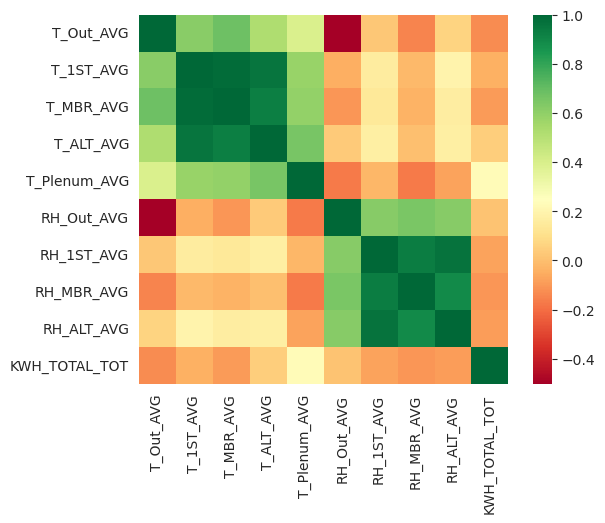

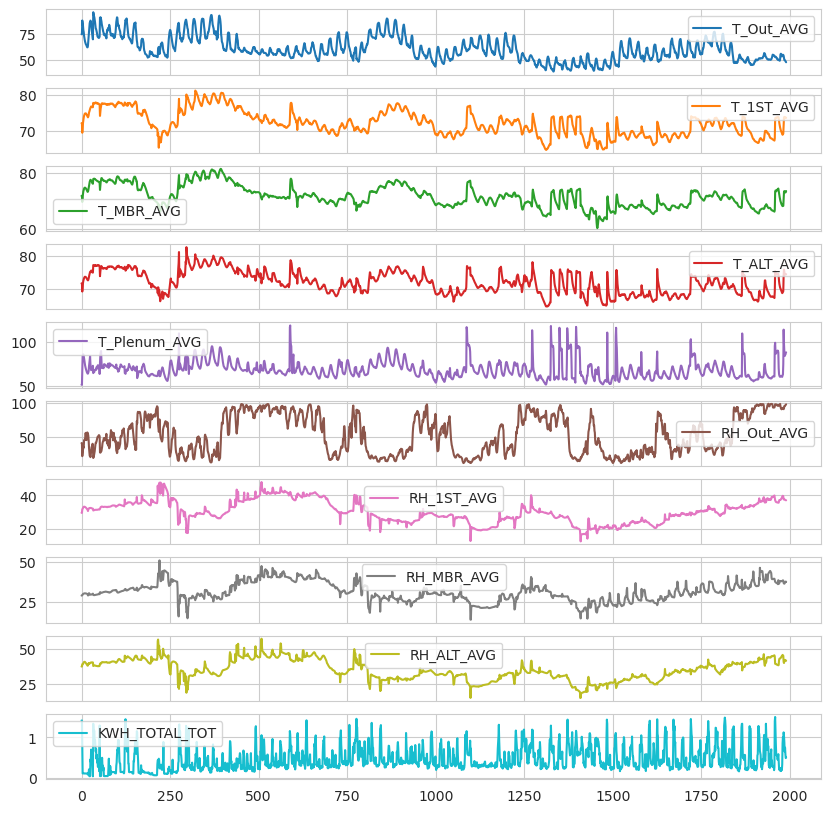

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot a correlation heatmap
correlation = df.corr()
print(correlation)
sns.heatmap(correlation, square=True, cmap='RdYlGn')
plt.show()

# Plot the time series
df.plot(subplots=True, figsize=(10, 10))
plt.show()

## Creating the features and labels

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class HouseDataset(Dataset):
    """House dataset."""
    
    def __init__(self, df, split: str = 'train'):
        self.X = df.drop(columns=['T_1ST_AVG']).to_numpy()
        self.y = df['T_1ST_AVG'].to_numpy()
        self.split = split
        
        # Split the data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=0.3, shuffle=False)
        
        print('X_train shape: {}'.format(self.X_train.shape))
        print('y_train shape: {}'.format(self.y_train.shape))
        print('X_test shape: {}'.format(self.X_test.shape))
        print('y_test shape: {}'.format(self.y_test.shape))
        
        
        # Scale the data
        self.scaler = MinMaxScaler()
        self.X_train = self.scaler.fit_transform(self.X_train)
        self.X_test = self.scaler.transform(self.X_test)
        
    def __len__(self):
        if self.split == 'train':
            return len(self.X_train)
        elif self.split == 'test':
            return len(self.X_test)
        else:
            raise ValueError('Invalid split type!')
        
    def __getitem__(self, idx):
        if self.split == 'train':
            # Convert the numpy arrays to PyTorch tensors
            return torch.from_numpy(self.X_train[idx]).float(), torch.tensor(self.y_train[idx]).float().unsqueeze(0)
        elif self.split == 'test':
            # Convert the numpy arrays to PyTorch tensors
            return torch.from_numpy(self.X_test[idx]).float(), torch.tensor(self.y_test[idx]).float().unsqueeze(0)
        else:
            raise ValueError('Invalid split type!')
        

In [6]:
# Create the dataset
train_ds = HouseDataset(df, split='train')
test_ds = HouseDataset(df, split='test')

# Create the dataloaders
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False)

# Print the shapes of the data
for x, y in test_dl:
    print(x.shape, y.shape)
    print(x.dtype, y.dtype)
    break

X_train shape: (1393, 9)
y_train shape: (1393,)
X_test shape: (597, 9)
y_test shape: (597,)
X_train shape: (1393, 9)
y_train shape: (1393,)
X_test shape: (597, 9)
y_test shape: (597,)
torch.Size([32, 9]) torch.Size([32, 1])
torch.float32 torch.float32


In [7]:
# Create the regression model
import torch
import torch.nn as nn
import torch.nn.functional as F

class RegressionModel(nn.Module):
    """Regression model."""
    
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, output_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)
    

In [8]:
# Create the model
model = RegressionModel(input_dim=9, output_dim=1)

# Print the model
print(model)


RegressionModel(
  (fc1): Linear(in_features=9, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
)


In [9]:
# Train the model
import torch.optim as optim

# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [10]:

# Define the number of epochs
n_epochs = 100
best_val_loss = np.inf
best_model = None

for epoch in range(n_epochs):
    # Set the model to train mode
    model.train()
    
    # Initialize the running loss
    running_loss = 0.0
    
    # Iterate over the training batches
    for i, (x, y) in enumerate(train_dl):
        # Reset the gradients
        optimizer.zero_grad()
        
        # Forward pass
        y_pred = model(x)
        
        # Compute the loss
        loss = criterion(y_pred, y)
        
        # Backward pass
        loss.backward()
        
        # Optimize the weights
        optimizer.step()
        
        # Update the running loss
        running_loss += loss.item()
        
    # Evaluate the model
    model.eval()
    
    # Initialize the validation loss
    val_loss = 0.0
    
    # Iterate over the validation batches
    for i, (x, y) in enumerate(test_dl):
        # Forward pass
        y_pred = model(x)
        
        # Compute the loss
        loss = criterion(y_pred, y)
        
        # Update the validation loss
        val_loss += loss.item()
    
    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model.state_dict()
        
    # Print the metrics
    print('Epoch {}, Loss (train/val): {:.3f}/{:.3f}'.format(
        epoch, running_loss / len(train_dl), val_loss / len(test_dl)))

Epoch 0, Loss (train/val): 5117.245/4093.452
Epoch 1, Loss (train/val): 2095.861/185.751
Epoch 2, Loss (train/val): 125.948/187.487
Epoch 3, Loss (train/val): 82.203/179.637
Epoch 4, Loss (train/val): 73.011/159.439
Epoch 5, Loss (train/val): 63.507/139.292
Epoch 6, Loss (train/val): 53.932/119.893
Epoch 7, Loss (train/val): 45.819/102.912
Epoch 8, Loss (train/val): 37.446/79.905
Epoch 9, Loss (train/val): 29.440/59.568
Epoch 10, Loss (train/val): 22.777/45.711
Epoch 11, Loss (train/val): 17.120/33.250
Epoch 12, Loss (train/val): 12.156/22.967
Epoch 13, Loss (train/val): 7.890/14.532
Epoch 14, Loss (train/val): 4.937/8.652
Epoch 15, Loss (train/val): 3.144/5.894
Epoch 16, Loss (train/val): 2.140/3.562
Epoch 17, Loss (train/val): 1.551/2.678
Epoch 18, Loss (train/val): 1.236/2.113
Epoch 19, Loss (train/val): 1.050/1.707
Epoch 20, Loss (train/val): 0.916/1.432
Epoch 21, Loss (train/val): 0.793/1.186
Epoch 22, Loss (train/val): 0.705/1.096
Epoch 23, Loss (train/val): 0.633/0.924
Epoch 24,

Outlier injected at row 56
Outlier injected at row 416
Outlier injected at row 429
Outlier injected at row 438
Outlier injected at row 611
Outlier injected at row 626
Outlier injected at row 770
Outlier injected at row 852
Outlier injected at row 979
Outlier injected at row 1057
Outlier injected at row 1103
Outlier injected at row 1213
Outlier injected at row 1224
Outlier injected at row 1232
Outlier injected at row 1280
Outlier injected at row 1404
Outlier injected at row 1521
Outlier injected at row 1600
Outlier injected at row 1668
Outlier injected at row 1728
Outlier injected at row 1873
Outlier injected at row 1880


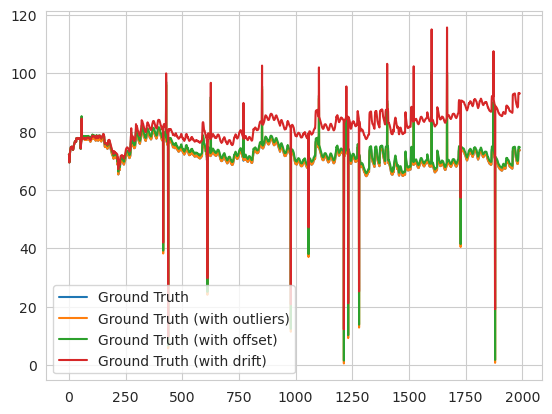

In [11]:
# Visualize the anomalies
import matplotlib.pyplot as plt

from utils import inject_outliers, inject_offset, inject_drift

data = df['T_1ST_AVG'].to_numpy()
data_outliers = inject_outliers(data, prob=0.01, outlier_threshold=3, limits=(0, 100))
data_offset = inject_offset(data, offset=1, failure_rate=100)
data_drift = inject_drift(data, drift_slope=0.01, failure_rate=100)

plt.plot(data, label='Ground Truth')
plt.plot(data_outliers, label='Ground Truth (with outliers)')
plt.plot(data_offset, label='Ground Truth (with offset)')
plt.plot(data_drift, label='Ground Truth (with drift)')
plt.legend()
plt.show()

Outlier injected at row 28
Outlier injected at row 120
Outlier injected at row 165
Outlier injected at row 336
Outlier injected at row 400
Outlier injected at row 466
Outlier injected at row 483


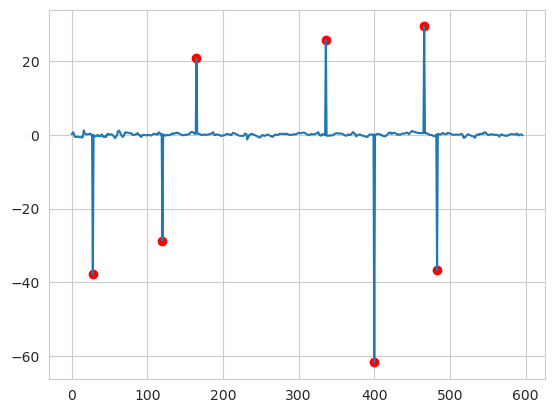

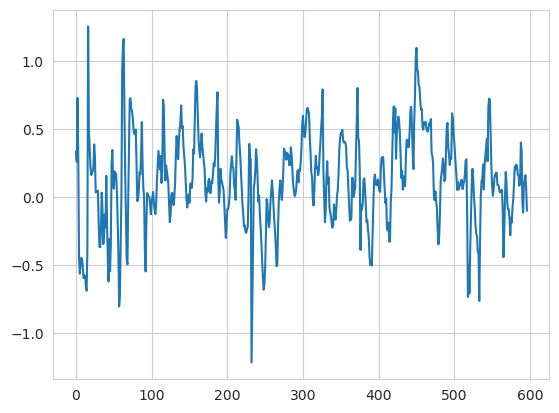

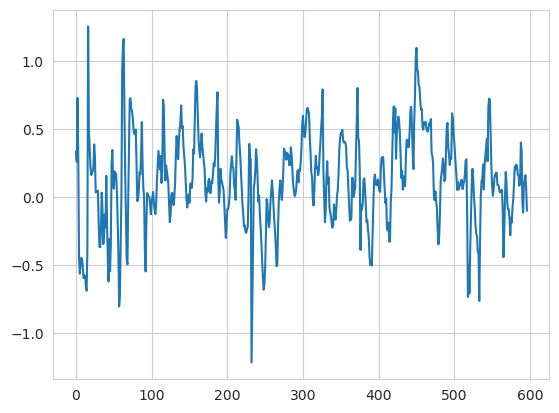

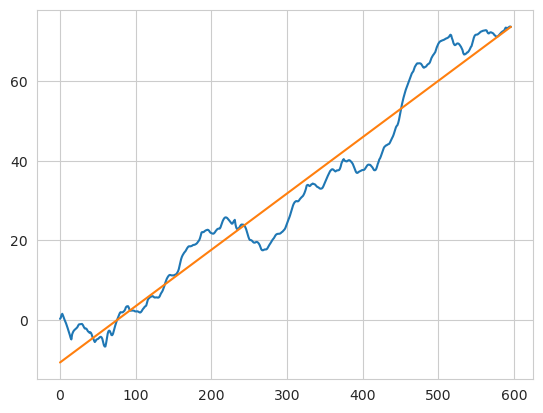

Model:  
0.1413 x - 10.62
Outliers: [-37.85659  -28.697414  20.839874  25.850227 -61.79276   29.482033
 -36.805664]


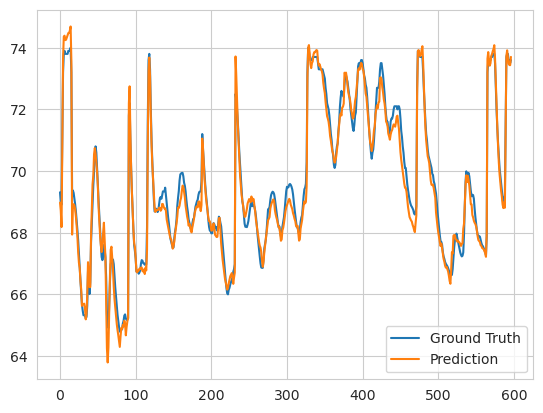

In [12]:
# Visualize the predictions
import matplotlib.pyplot as plt

from utils import inject_outliers, inject_offset, inject_drift
from utils import detect_anomalies

true_time_series = df['T_1ST_AVG'].to_numpy()
test_dl = DataLoader(test_ds, batch_size=len(test_ds), shuffle=False)

# Set the model to eval mode
model.eval()
for x, y in test_dl:
    y_pred = model(x)
    y_pred = y_pred.detach().numpy().flatten()
    y_true = y.detach().numpy().flatten()
    y_true_outliers = inject_outliers(y_true, prob=0.01, outlier_threshold=3, limits=(0, 100))
    y_true_offset = inject_offset(y_true_outliers, offset=1, failure_rate=100)
    y_true_drift = inject_drift(y_true_outliers, drift_slope=0.01, failure_rate=100)
    break
    
detect_anomalies(y_true_outliers, y_pred, error_threshold=0.5, outlier_threshold=1)
    
# Plot the time series
plt.plot(y_true, label='Ground Truth')
# plt.plot(y_true_outliers, label='Ground Truth (with outliers)')
# plt.plot(y_true_offset, label='Ground Truth (with offset)')
# plt.plot(y_true_drift, label='Ground Truth (with drift)')
plt.plot(y_pred, label='Prediction')
plt.legend()
plt.show()

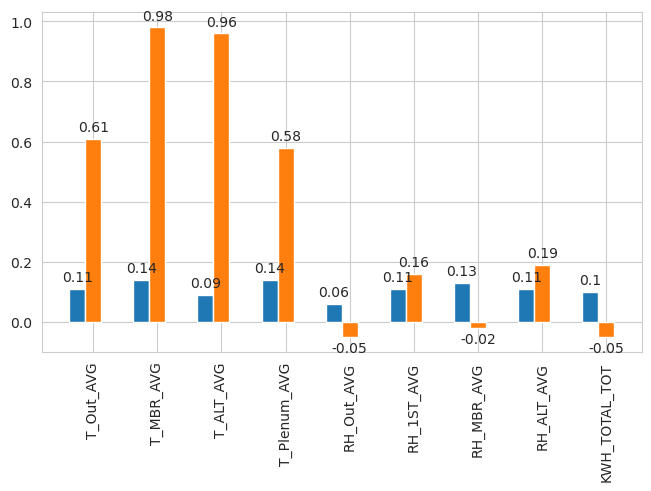

In [13]:
# Visualize the correlations with the weights of the first layer
import matplotlib.pyplot as plt

labels = ['T_Out_AVG', 'T_MBR_AVG', 
           'T_ALT_AVG', 'T_Plenum_AVG', 'RH_Out_AVG', 
           'RH_1ST_AVG', 'RH_MBR_AVG', 'RH_ALT_AVG', 'KWH_TOTAL_TOT']

# Get the weights of the first layer
weights = model.fc1.weight.detach().numpy()
mean_weights = np.mean(weights, axis=0)
normalized_weights = np.abs(mean_weights) / np.sum(np.abs(mean_weights))
# Round the weights to 2 decimal places
normalized_weights = np.round(normalized_weights, 2)

# Get the correlations without the T_1ST_AVG
correlations = df.corr()['T_1ST_AVG'].drop('T_1ST_AVG').to_numpy()

# Round the correlations to 2 decimal places
correlations = np.round(correlations, 2)

# Plot the weights and the correlations as the bar charts with labels
fig, ax = plt.subplots(layout='constrained')
width = 0.25  # the width of the bars
multiplier = 0

x = np.arange(len(mean_weights))

rects = ax.bar(x, normalized_weights, width, label='Weights')
ax.bar_label(rects, padding=3)

rects = ax.bar(x + width, correlations, width, label='Correlations')
ax.bar_label(rects, padding=3)

ax.set_xticks(x + width, labels)
ax.set_xticklabels(labels, rotation=90)
plt.show()
